# ChatGPT Tweets Sentiment Analysis

ChatGPT is a powerful LLM created by OpenAI which has been a recently gained a lot of popularity due to its ablility to perform a wide variety of tasks well and gained a lot of attention on social media platforms where people have been discussing about it. To identify the net sentiment of the public regarding the public, in this project I aim to:
1) Analyse the sentiment of tweets.
2) Identify underlying trends in tweet patterns.
3) Identify what are the possible broad topics of discussion in tweets(based on their Sentiment.)
## Dataset Pre-Processing
<b>Importing Libraries relevant libraries:<b>


In [8]:
# data analysis and manipulation libraries
import numpy as np 
import pandas as pd 
from datetime import timedelta
# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from wordcloud import WordCloud
# libraries for nlp tasks
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# Model used for Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer
# For topic modelling
import gensim
from sklearn.feature_extraction.text import CountVectorizer
import pyLDAvis.gensim
from gensim.corpora.dictionary import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
# for storing objects as pickle files
import pickle
# Counting items in a list and returning as a dictionary
from collections import Counter
# library for statistical analysis 
from scipy import stats
# Disable all warnings
import warnings
warnings.filterwarnings("ignore")
#import imaging Library
from PIL import Image

<b>Dealing with Null and improperly entered values:</b>

The data set seems to have few missing values, since they are very few. I had chosen to delete them. Also, some of the values were entered incorrectly therefore, those were also decided to be deleted. Therefore, there might be some bias towards the total number of tweets, but should not affect the overall sentiment that much.

In [9]:
# importing the dataset
df = pd.read_csv("ChatGPT_Twitter_Data.csv")
def convert_to_datetime(x):
    try:
        return pd.to_datetime(x)
    except:
        return np.nan
df['date'] = df['date'].apply(lambda x: convert_to_datetime(x))
print("Null values Count, Prior to any Processing:")
print(df.isnull().sum())
df = df.dropna()
df["date only"] = df["date"].dt.date 
df = df.drop("id", axis=1) #id not providing any useful information
print("Null values Count, After Processing:")
print(df.isnull().sum())
df.head(5)

Null values Count, Prior to any Processing:

date             34

id                6

content           6

username         34

like_count       62

retweet_count    62

dtype: int64

Null values Count, After Processing:

date             0

content          0

username         0

like_count       0

retweet_count    0

date only        0

dtype: int64


date  \
0 2023-03-29 22:58:21+00:00   
1 2023-03-29 22:58:18+00:00   
2 2023-03-29 22:57:53+00:00   
3 2023-03-29 22:57:52+00:00   
4 2023-03-29 22:57:26+00:00   

                                             content        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count   date only  
0         0.0            0.0  2023-03-29  
1         0.0            0.0  2023-03-29  
2         0.0            0.0  2023-03-29  
3         0.0            0.0  2023-03-29  
4         0.0            0.0  2023-03-29

### Text processing for Sentiment analysis
For the Sentiment Analysis of the tweets, we have decided to use the VADER(Valence Aware Dictionary for Sentiment Reasoning) which has been designed for Social Media Sentiment Analysis. Another advantage it posseses is that it does not require a lot of preprocessing. However, the text data will be processed to use for Topic Modelling later.
- Pre-processing for Sentiment Analysis: hastag, url, account mention removal
- Pre-processing for LDA: same as Sentiment analysis + expand contractions, remove punctuations and emoticons, remove stop words, lowercase all text

In [10]:
# Extract out hashtags in the tweets
df["accounts_mentioned"] = df["content"].apply(lambda x: re.findall("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)", x) )
# Extract out mentioned accounts in the tweets
df["hashtags"] = df["content"].apply(lambda x: re.findall("#(\w+)",x))
tweets = df["content"] #df with only tweets
# remove urls
tweets = tweets.apply(lambda x: re.sub('http\S+', '', x))
# remove mentions
tweets = tweets.apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)", '', x))
# remove hashtags
tweets = tweets.apply(lambda x: re.sub("#(\w+)", '', x))
# expand contractions
import contractions
tweets = tweets.apply(lambda x: contractions.fix(x))
# remove punctuations and emoticons
tweets = tweets.apply(lambda x: re.sub('[^\w\s]', '', x))
# remove stop words
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
tweets = tweets.apply(lambda x: " ".join([w for w in x.split() if w.lower() not in stop_words]) )
# lower case all words
tweets = tweets.apply(lambda x: x.lower() )
df = pd.merge(df, tweets, how="inner", left_index=True, right_index=True)
# lemmatize the words after tokenizing
df['content_y'] = df['content_y'].apply(lambda x: word_tokenize(x))
lemmatizer = WordNetLemmatizer()
df['content_y'] = df['content_y'].apply(lambda x: " ".join([lemmatizer.lemmatize(i) for i in x]) )
# remove hashtags, urls and accounts mentioned
df["content_to_input"] = df["content_x"]
df["content_to_input"] = df["content_to_input"].apply(lambda x: re.sub('http\S+', '', x))
df["content_to_input"] =  df["content_to_input"].apply(lambda x: re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9_]+)", '', x))
df["content_to_input"] = df["content_to_input"].apply(lambda x: re.sub("#(\w+)", '', x))
df.head(5)

date  \
0 2023-03-29 22:58:21+00:00   
1 2023-03-29 22:58:18+00:00   
2 2023-03-29 22:57:53+00:00   
3 2023-03-29 22:57:52+00:00   
4 2023-03-29 22:57:26+00:00   

                                           content_x        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   
4  Most people haven't heard of Chat GPT yet.\nFi...   nikocosmonaut   

   like_count  retweet_count   date only accounts_mentioned  \
0         0.0            0.0  2023-03-29                 []   
1         0.0            0.0  2023-03-29   [MecoleHardman4]   
2         0.0            0.0  2023-03-29                 []   
3         0.0            0.0  2023-03-29                 []   
4         0.0            0.0  2023-03-29                 []   

                                   hashtags  \
0                                 [ChatGPT]   
1                                        []   
2              [research, chatpdf, ChatGPT]   
3  [OutOfContextAI, AILifeLessons, ChatGPT]   
4                                        []   

                                           content_y  \
0  free ai marketing automation tool strategy col...   
1                                    chat gpt say 15   
2  chat pdf check new ai quickly answer question ...   
3  ai mus court life must face judge destiny jury...   
4  people heard chat gpt yet first elite faction ...   

                                    content_to_input  
0  Free AI marketing and automation tools, strate...  
1                           Chat GPT says it’s 15. 😂  
2   - Chat with any PDF!\nCheck out how this new ...  
3  AI muses: "In the court of life, we must all f...  
4  Most people haven't heard of Chat GPT yet.\nFi...

## Sentiment Analysis
Utilizing VADER model to identify the sentiment of the tweets.

In [11]:
sid = SentimentIntensityAnalyzer()
df["Polarity Scores"] = df["content_to_input"].apply(lambda x: sid.polarity_scores(x))
def sentiment_label(x):
    if x["compound"]>0.05:
        return "Positive"
    elif x["compound"]<-0.05:
        return "Negative"
    else: 
        return "Neutral"
df["Sentiment_Label"] = df["Polarity Scores"].apply(lambda x: sentiment_label(x))
df = df.drop("Polarity Scores", axis=1)
df.head(4)

date  \
0 2023-03-29 22:58:21+00:00   
1 2023-03-29 22:58:18+00:00   
2 2023-03-29 22:57:53+00:00   
3 2023-03-29 22:57:52+00:00   

                                           content_x        username  \
0  Free AI marketing and automation tools, strate...  RealProfitPros   
1           @MecoleHardman4 Chat GPT says it’s 15. 😂    AmyLouWho321   
2  https://t.co/FjJSprt0te - Chat with any PDF!\n...      yjleon1976   
3  AI muses: "In the court of life, we must all f...  ChatGPT_Thinks   

   like_count  retweet_count   date only accounts_mentioned  \
0         0.0            0.0  2023-03-29                 []   
1         0.0            0.0  2023-03-29   [MecoleHardman4]   
2         0.0            0.0  2023-03-29                 []   
3         0.0            0.0  2023-03-29                 []   

                                   hashtags  \
0                                 [ChatGPT]   
1                                        []   
2              [research, chatpdf, ChatGPT]   
3  [OutOfContextAI, AILifeLessons, ChatGPT]   

                                           content_y  \
0  free ai marketing automation tool strategy col...   
1                                    chat gpt say 15   
2  chat pdf check new ai quickly answer question ...   
3  ai mus court life must face judge destiny jury...   

                                    content_to_input Sentiment_Label  
0  Free AI marketing and automation tools, strate...        Positive  
1                           Chat GPT says it’s 15. 😂         Neutral  
2   - Chat with any PDF!\nCheck out how this new ...        Positive  
3  AI muses: "In the court of life, we must all f...         Neutral

## Exploratory Analysis of Tweets



### Sentiment Distribution
The dataset was split into 3 sentimemnt based on the compound polarity score calculated by the VADER model.
The criteria was:
- if >0.05, classify as positive
- if <-0.05, classify as negative
- else, classify as neutral

The distribution of the tweets predicted by the model is:
- 249.538k Tweets classified as Positive(49.91%)
- 170.685k Tweets classified as Negative(34.14%)
- 79.752k Tweets classified as Negative(15.95%)

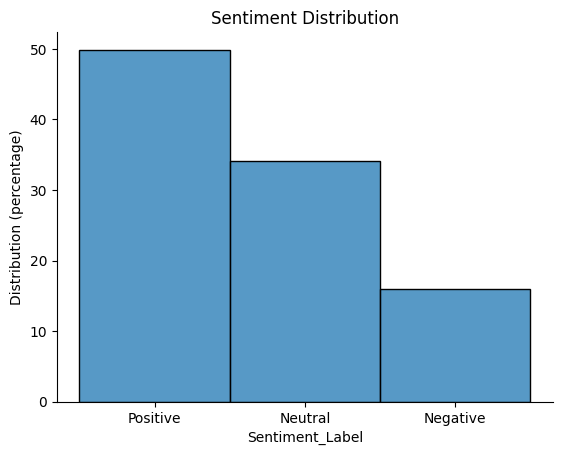

In [12]:
ax = sns.histplot(data=df, x="Sentiment_Label", stat="percent" )
plt.title("Sentiment Distribution")
plt.ylabel("Distribution (percentage)")
ax.spines[['right', 'top']].set_visible(False)


Divide the dataframe into 3 child dataframes based on sentiment.

In [13]:
df_pos = df[df["Sentiment_Label"]=="Positive"]
df_neu = df[df["Sentiment_Label"]=="Neutral"]
df_neg = df[df["Sentiment_Label"]=="Negative"]

### <b>Trend in Tweet Sentiment
#### Overall Tweets Trend </b>
Based on the timeseries plot, there can be said there has been somewhat a constant trend however, there does seem to be some sort of cyclical behaviour. When the timeseries plot has been overlayed by Sentiment, we can infer that sentiment towards ChatGPT has remained poisitive

<b>Anomalies</b>

It can be observed that the number of tweets on 2023-02-07 and 2023-03-15 seem to be abnormally high. Therefore, we will investigate the events that occured on that day related to ChatGPT. 


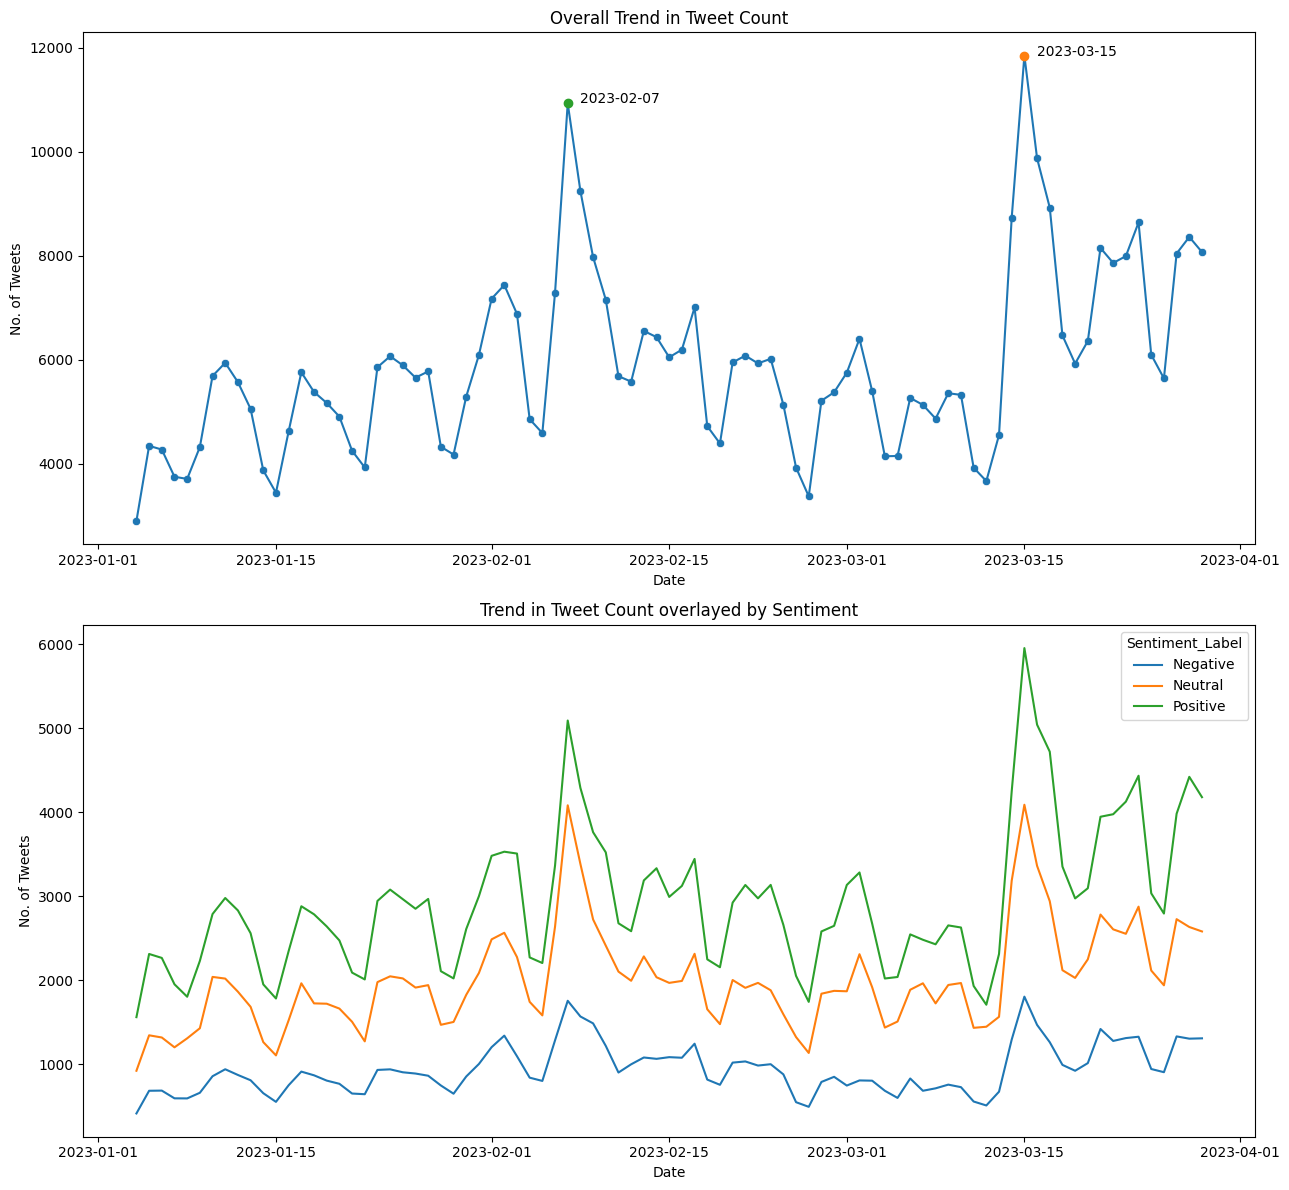

In [14]:
df_grouped_date_sentiment = df.groupby(by=["date only","Sentiment_Label"],as_index=False).count()
df_grouped_date = df.groupby(by=["date only"],as_index=False).count()
df_grouped_date = df_grouped_date[["date only","content_x"]] 
df_grouped_date_sentiment = df_grouped_date_sentiment[["date only","Sentiment_Label","content_x"]]
max_2 = df_grouped_date.sort_values(by="content_x",ascending=False).iloc[:2]
fig = plt.subplots(2,1,figsize=(13,12))
plt.subplot(2,1,1)
sns.lineplot(data=df_grouped_date , x="date only",y="content_x")
sns.scatterplot(data=df_grouped_date , x="date only",y="content_x")
plt.ylabel("No. of Tweets")
plt.xlabel("Date")
plt.title("Overall Trend in Tweet Count")
plt.text(max_2["date only"].iloc[1]+timedelta(days=1), max_2["content_x"].iloc[1], str(max_2["date only"].iloc[1]))
plt.text(max_2["date only"].iloc[0]+timedelta(days=1), max_2["content_x"].iloc[0], str(max_2["date only"].iloc[0]))
plt.plot(max_2["date only"].iloc[0], max_2["content_x"].iloc[0],marker='o')
plt.plot(max_2["date only"].iloc[1], max_2["content_x"].iloc[1],marker='o')
plt.tight_layout()
plt.subplot(2,1,2)
sns.lineplot(data=df_grouped_date_sentiment , x="date only",y="content_x", hue="Sentiment_Label", legend="full")
plt.ylabel("No. of Tweets")
plt.xlabel("Date")
plt.title("Trend in Tweet Count overlayed by Sentiment")
plt.tight_layout()

#### <b>Seasonality</b>



<I>Hourly Seasonality</I>

There is an observable trend in the number of tweets that grow from 0 to 13 hours and plateus till 18 hours and then decreases with time.

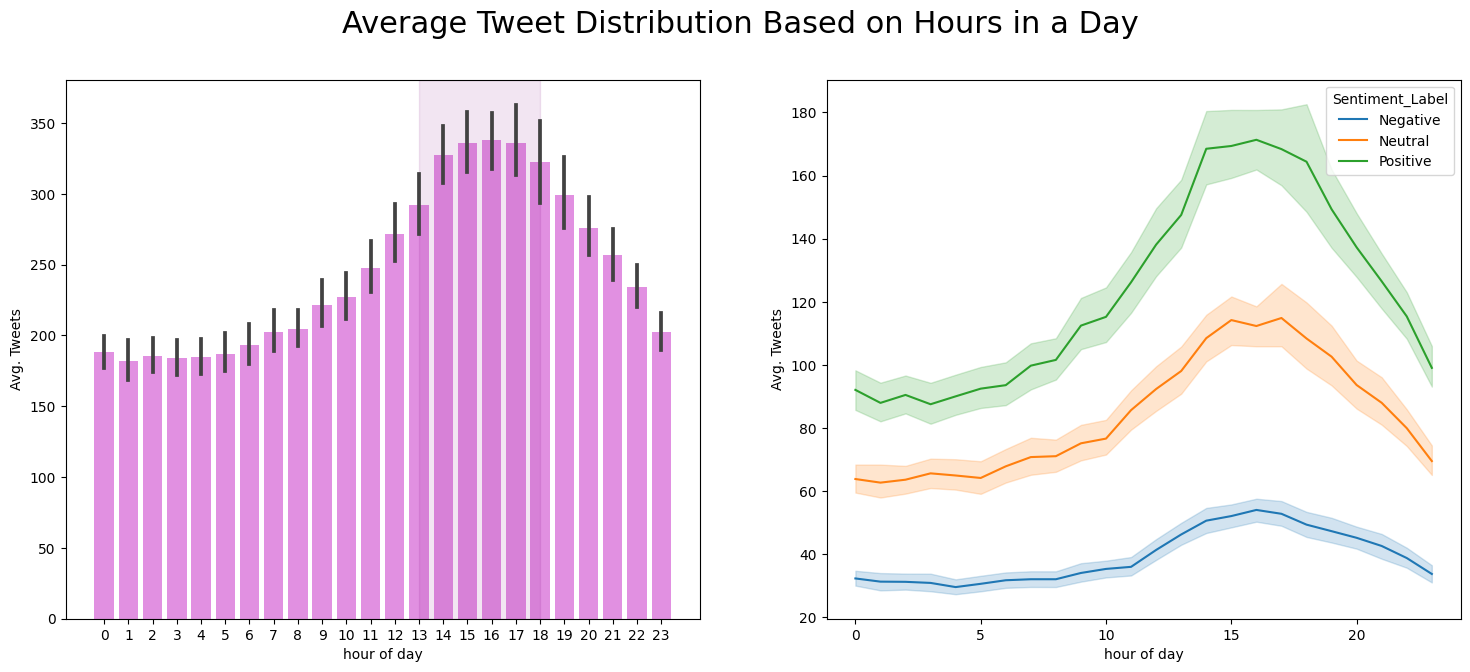

In [15]:
time =df[["date", 'date only', "Sentiment_Label"]]
time["hour of day"] = time["date"].dt.hour
# pandas df representing number of tweets every hour grouped by day and sentiment label. 
hourly = time.groupby(by=["date only",'hour of day',"Sentiment_Label"],as_index=False).count()
hourly["Tweet Count"] =hourly["date"]
hourly_sentiment = hourly.drop(["date","date only"], axis=1)
# group by df without sentiment label
hourly_non_sentiment = time.groupby(by=["date only",'hour of day'],as_index=False).count()
hourly_non_sentiment ["Tweet Count"] =hourly_non_sentiment ["date"]
hourly_non_sentiment = hourly_non_sentiment.drop(["date","date only","Sentiment_Label"], axis=1)
fig, axes = plt.subplots(1,2,figsize=(18,7))
plt.suptitle("Average Tweet Distribution Based on Hours in a Day", size=22)
plt.subplot(1,2,1)
ax1 = sns.barplot(data=hourly_non_sentiment, x='hour of day', y="Tweet Count", color="violet")
plt.axvspan(13, 18, color='purple', alpha=0.1)
plt.ylabel("Avg. Tweets")
plt.subplot(1,2,2)
ax2 = sns.lineplot(data=hourly_sentiment, x='hour of day', y="Tweet Count", hue="Sentiment_Label")
plt.ylabel("Avg. Tweets")
plt.show()

<I>Days of the Week Seasonality</I>

Twitter activity tends to be relatively lower during weekends, compared to week days.

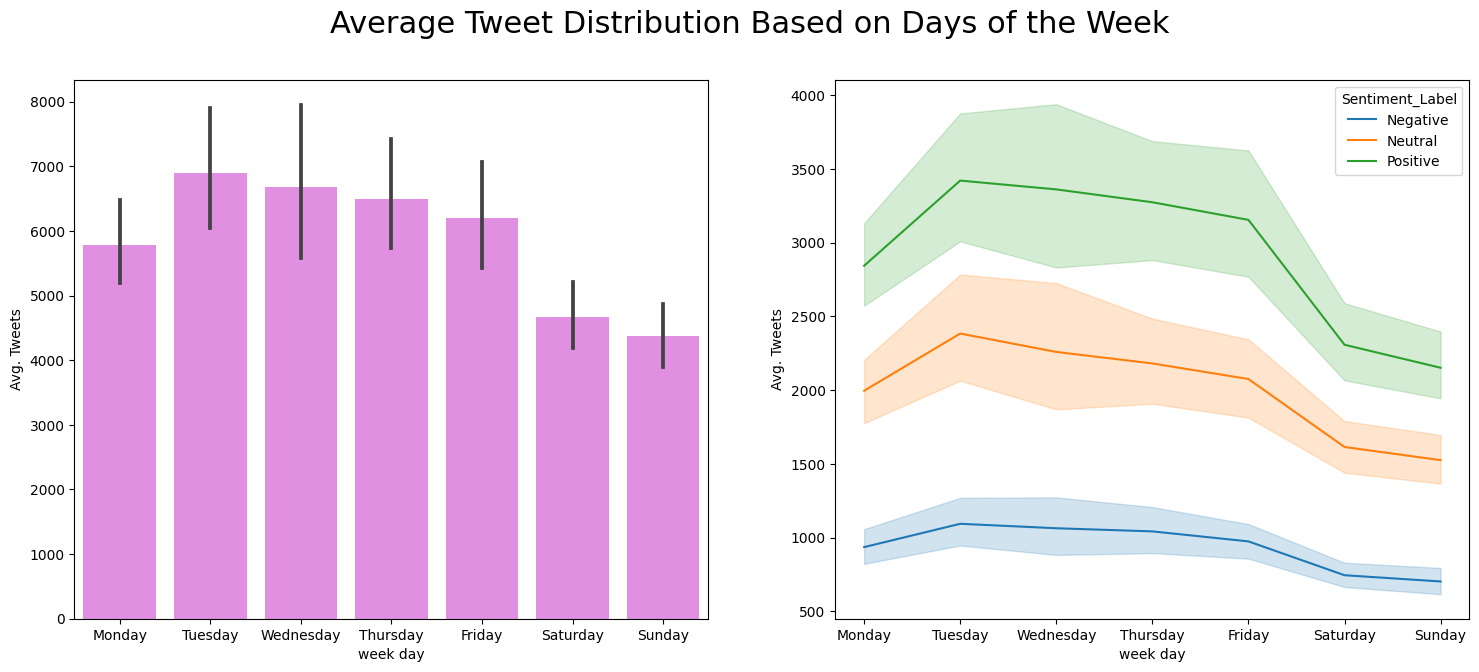

In [16]:
time =df[["date", 'date only', "Sentiment_Label"]]
time["week day"] = time["date"].dt.day_of_week
# pandas df representing number of tweets every hour grouped by day and sentiment label. 
week_day = time.groupby(by=["date only",'week day',"Sentiment_Label"],as_index=False).count()
week_day["Tweet Count"] =week_day["date"]
week_day = week_day.drop(["date","date only"], axis=1)
#week_day_sentiment = week_day.groupby(by=['week day',"Sentiment_Label"],as_index=False).mean()
# group by df without sentiment label
week_day_non_sentiment = time.groupby(by=["date only",'week day'],as_index=False).count()
week_day_non_sentiment ["Tweet Count"] =week_day_non_sentiment ["date"]
week_day_non_sentiment = week_day_non_sentiment.drop(["date","date only","Sentiment_Label"], axis=1)
#week_day_non_sentiment = week_day_non_sentiment.groupby(by=['week day'],as_index=False).mean()
fig, axes = plt.subplots(1,2,figsize=(18,7))
plt.suptitle("Average Tweet Distribution Based on Days of the Week", size=22)
plt.subplot(1,2,1)
ax1 = sns.barplot(data=week_day_non_sentiment , x='week day', y="Tweet Count", color="violet")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.ylabel("Avg. Tweets")
plt.subplot(1,2,2)
ax2 = sns.lineplot(data=week_day , x='week day', y="Tweet Count", hue="Sentiment_Label")
plt.xticks([0, 1, 2, 3, 4, 5, 6], ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.ylabel("Avg. Tweets")
plt.show()


2023-02-07

Words like google and microsoft seem to appear on the wordclouh, could imply about events that happened before and after 2023-02-07. After a quick google search, I identified the possible events to be.
1) BardAI was released on 6th Jun. And 7th June, it made a mistake. 
2) Microsoft announces integration of ChatGPT with Bing. 


(-0.5, 399.5, 199.5, -0.5)

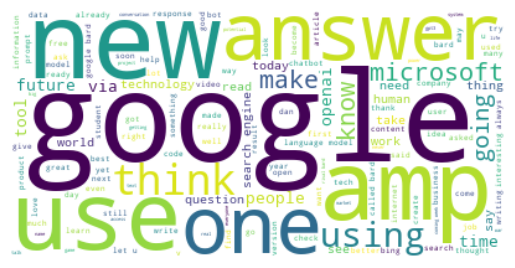

In [17]:
def remove_extra_words(x):
    extra_words = ["chat", "gpt", "ai", "artificial", "intelligence", "chatgpt", "gpt4"]
    b = x.split()
    c =[]
    for i in b:
        if i.lower() in extra_words:
            continue
        c.append(i)
    return " ".join(c)
df_7feb = df[df["date only"] == pd.to_datetime("2023-02-07").date() ]
df_7feb["content_y"] = df_7feb["content_y"].apply(remove_extra_words)
long_text = " ".join([i for i in df_7feb["content_y"].values])
w_cloud = WordCloud(background_color="white", max_words=3000, contour_width=5, contour_color='steelblue')
w_cloud.generate(long_text)
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis('off')

2023-03-15

Words like new and open ai are prominent words, whcih could imply something new by OpenAI. GPT-4 was released on 14th March, therefore, the tweet surge could be explained due to its release.

(-0.5, 399.5, 199.5, -0.5)

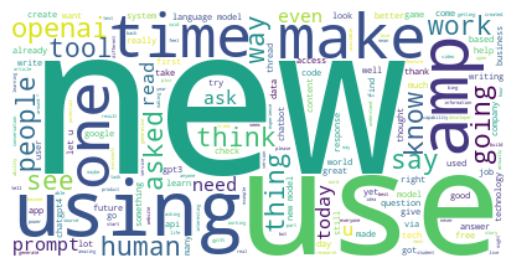

In [18]:
df_15mar = df[df["date only"] == pd.to_datetime("2023-03-15").date() ]
df_15mar["content_y"] = df_15mar["content_y"].apply(remove_extra_words)
long_text = " ".join([i for i in df_15mar["content_y"].values])
w_cloud = WordCloud(background_color="white", max_words=3000, contour_width=5, contour_color='steelblue')
w_cloud.generate(long_text)
plt.imshow(w_cloud, interpolation='bilinear')
plt.axis('off')

### Topic Modelling based on Sentiment


##### Setting Up of Models
For identifying potential topics of tweets, we use the divided dataframes(based on sentiments), and remove some extra words and all words less than length 3 as to include only important words.

Following that, the text data was processed a bit more to be used for LDA:
1) Count Vectorize the words
2) Conversion of the sparse matrix to a Gensim Corpus
3) Create a dicitonary to map IDs to words.
4) Train 3 LDA models to identify the topics in the tweets to uncover reasons behind the sentiment of the tweets.

Based on the words the defined number of topics were inferenced. Though, the Topic names are based on my POV. The topic model visulaizations can be accessed through the HTML files.

Furthermore, I have also desiplayed the distribution of those topics across the tweets.

In [19]:
# tweets after all pre-processing
pos_tweet = df_pos["content_y"]
neg_tweet = df_neg["content_y"]
neu_tweet = df_neu["content_y"]
# remove all words containg chat, gpt, ai, artificial, intelligence
def remove_extra_words(x):
    extra_words = ["chat", "gpt", "ai", "artificial", "intelligence", "chatgpt", "gpt4"]
    b = x.split()
    c =[]
    for i in b:
        if i.lower() in extra_words:
            continue
        c.append(i)
    return " ".join(c)
pos_tweet = pos_tweet.apply(lambda x: remove_extra_words(x))
neg_tweet  = neg_tweet.apply(lambda x: remove_extra_words(x))
neu_tweet  = neu_tweet.apply(lambda x: remove_extra_words(x))
# remove words less than 3 letters in length
def rless3(x):
    b = x.split()
    c =[]
    for i in b:
        if len(i)<=3:
            continue
        c.append(i)
    return " ".join(c)
pos_tweet = pos_tweet.apply(lambda x: rless3(x))
neg_tweet  = neg_tweet.apply(lambda x: rless3(x))
neu_tweet  = neu_tweet.apply(lambda x: rless3(x))
# Count vectorization
vect_pos = CountVectorizer(min_df=20, ngram_range = (1,1))
vect_neg = CountVectorizer(min_df=20, ngram_range = (1,1))
vect_neu = CountVectorizer(min_df=20, ngram_range = (1,1))
# Fit and transform
X_pos = vect_pos.fit_transform(pos_tweet)
X_neg = vect_neg.fit_transform(neg_tweet)
X_neu = vect_neu.fit_transform(neu_tweet)
# Convert sparse matrix to gensim corpus.
corpus_pos = gensim.matutils.Sparse2Corpus(X_pos, documents_columns=False)
corpus_neg = gensim.matutils.Sparse2Corpus(X_neg, documents_columns=False)
corpus_neu = gensim.matutils.Sparse2Corpus(X_neu, documents_columns=False)
# Mapping from word IDs to words (To be used in LdaModel's id2word parameter)
id_map_pos = dict((v, k) for k, v in vect_pos.vocabulary_.items())
id_map_neg = dict((v, k) for k, v in vect_neg.vocabulary_.items())
id_map_neu = dict((v, k) for k, v in vect_neu.vocabulary_.items())
# Training LDA Models
topic_num_pos = 4
topic_num_neg = 3
topic_num_neu = 3

In [20]:
ldamodel_pos = gensim.models.ldamodel.LdaModel(corpus=corpus_pos, id2word=id_map_pos,num_topics=topic_num_pos, random_state=23,passes=15)
ldamodel_neg = gensim.models.ldamodel.LdaModel(corpus=corpus_neg, id2word=id_map_neg,num_topics=topic_num_neg, random_state=3,passes=15)
ldamodel_neu = gensim.models.ldamodel.LdaModel(corpus=corpus_neu, id2word=id_map_neu,num_topics=topic_num_neu, random_state=5,passes=15)

In [21]:
dict = {"pos": [ldamodel_pos, vect_pos ] , "neg": [ldamodel_neg, vect_neg ], "neu":[ldamodel_neu, vect_neu] }
def topic_model(x, sentiment):
    x_l = []
    x_l.append(x)
    x_vect = dict[sentiment][1].transform(x_l)
    corpus = gensim.matutils.Sparse2Corpus(x_vect, documents_columns=False)
    topic = dict[sentiment][0].get_document_topics(corpus)
    max_p = 0
    mp_topic = 0
    for i in topic[0]:
        if i[1]>max_p:
            max_p = i[1]
            mp_topic = i[0] 
    return mp_topic

pos_tweet_df = pd.DataFrame(pos_tweet)
neg_tweet_df = pd.DataFrame(neg_tweet) 
neu_tweet_df = pd.DataFrame(neu_tweet) 
pos_tweet_df["Topic"] = pos_tweet_df["content_y"].apply(lambda x: topic_model(x,"pos"))
neg_tweet_df["Topic"] = neg_tweet_df["content_y"].apply(lambda x: topic_model(x,"neg"))
neu_tweet_df["Topic"] = neu_tweet_df["content_y"].apply(lambda x: topic_model(x,"neu"))

##### Possible Topics in Postive Tweets

Based on the word, in the plots. We can make a subjective inference about possible topics.

Topic 1: Interaction of humans with ChatGPT

Topic 2: Usefulness in Education

Topic 3: LLMs and Search Engines

Topic 4: Potenitals of AI in the future 

In [22]:
pyLDAvis.enable_notebook()
corpus_dict = Dictionary.from_corpus(corpus_pos, id2word=ldamodel_pos.id2word)
vis = pyLDAvis.gensim.prepare(ldamodel_pos, corpus_pos, dictionary=corpus_dict )
pyLDAvis.save_html(vis, 'lda_pos.html')# Can be viewed in html file

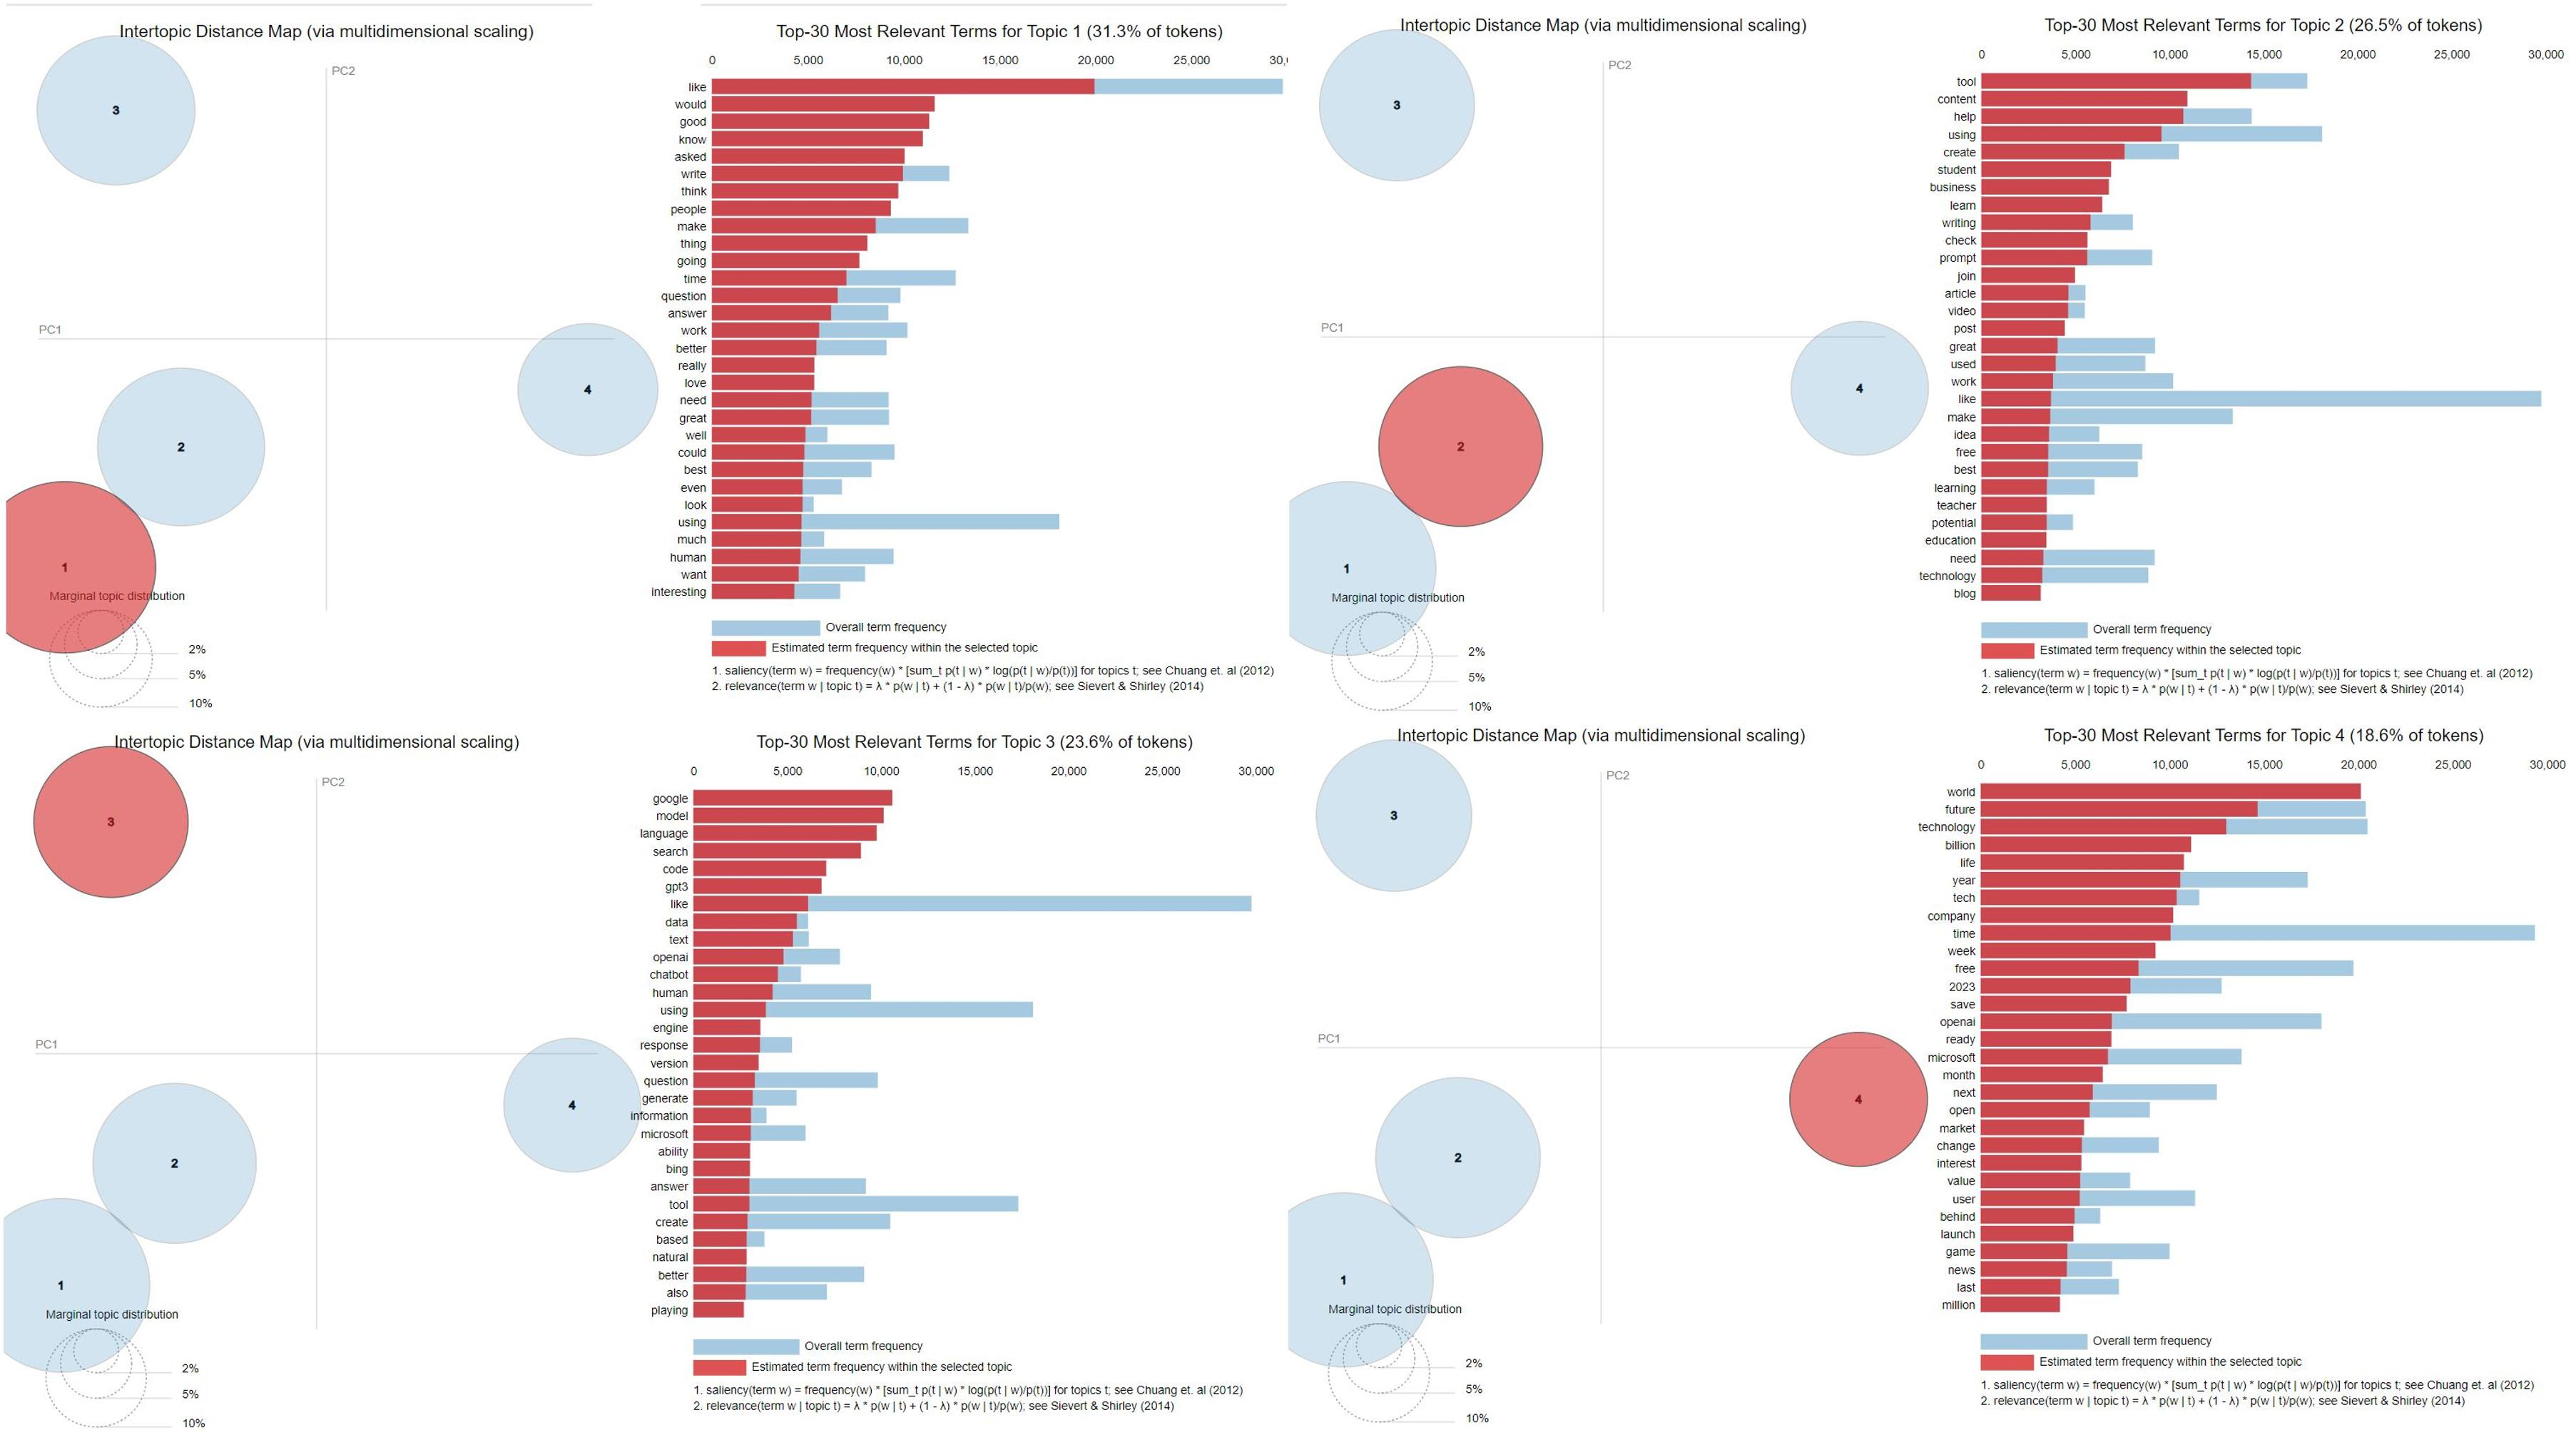

In [23]:
Image.open("contact_pos.jpg")


Distribution of the Topics in Tweets:

In [ ]:
topics_pos = {0:"Interaction of \n humans with ChatGPT", 1:"Usefulness in \n Education", 2:"LLMs and Search \n Engines", 3:"Potenitals of AI \n in the future"}
pos_tweet_df["Topic"] = pos_tweet_df["Topic"].apply(lambda x: topics_pos[x])

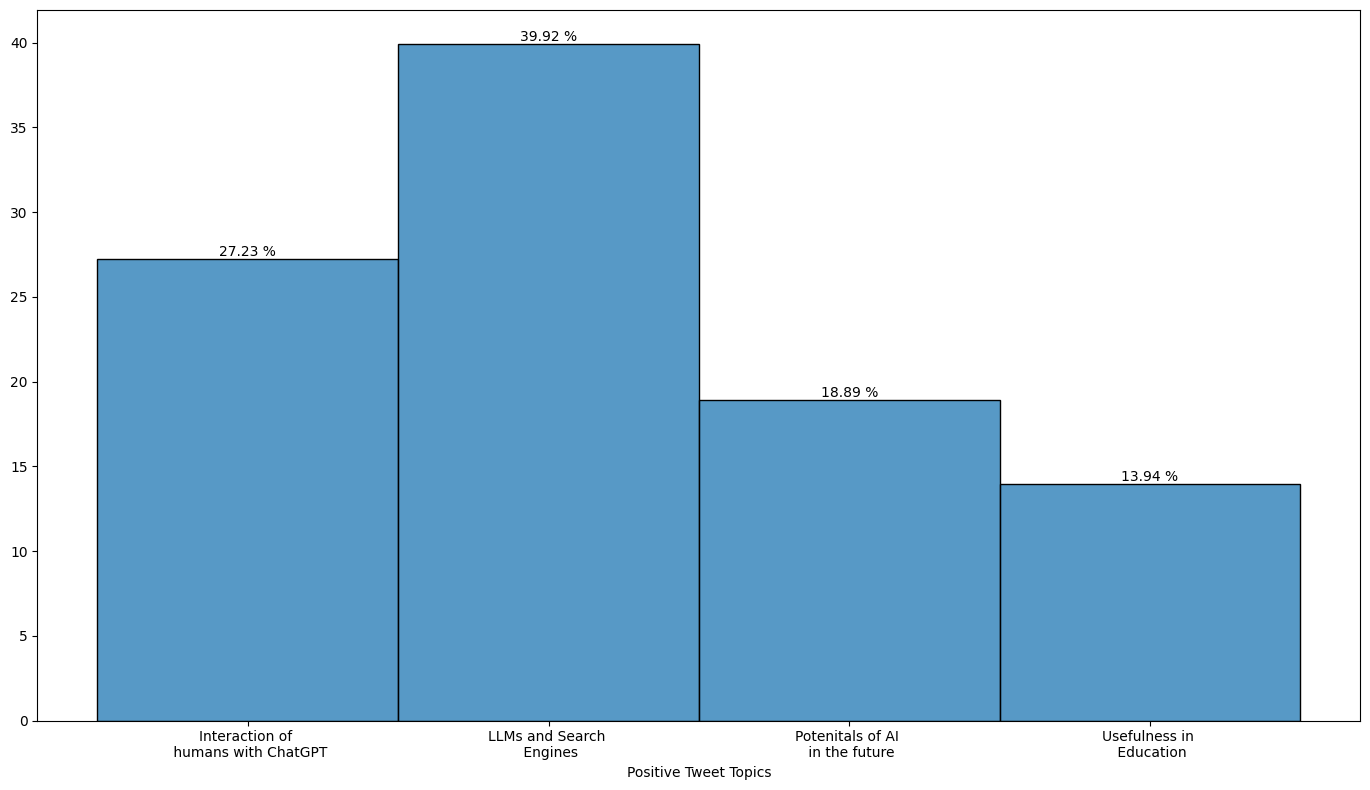

In [50]:
plt.figure(figsize=(14,8))
ax1 = sns.histplot(data=pos_tweet_df, x="Topic", stat="percent" )
plt.tight_layout()
plt.ylabel("")
plt.xlabel("Positive Tweet Topics")
rects = ax1.patches
for rect in rects:
    height = rect.get_height()
    ax1.text(
        rect.get_x() + rect.get_width() / 2, height, str(height)[:5] + " %", ha="center", va="bottom"
    )

##### Possible Topics in Negative Tweets

Based on the word, in the plots. We can make a subjective inference about possible topics.

Topic 1: It's Limitations

Topic 2: Regarding using ChatGPT for writing tasks

Topic 3: Risks involved during the use of ChatGPT

In [24]:
pyLDAvis.enable_notebook()
corpus_dict = Dictionary.from_corpus(corpus_neg, id2word=ldamodel_neg.id2word)
vis = pyLDAvis.gensim.prepare(ldamodel_neg, corpus_neg, dictionary=corpus_dict )
pyLDAvis.save_html(vis, 'lda_neg.html')# Can be viewed in html file

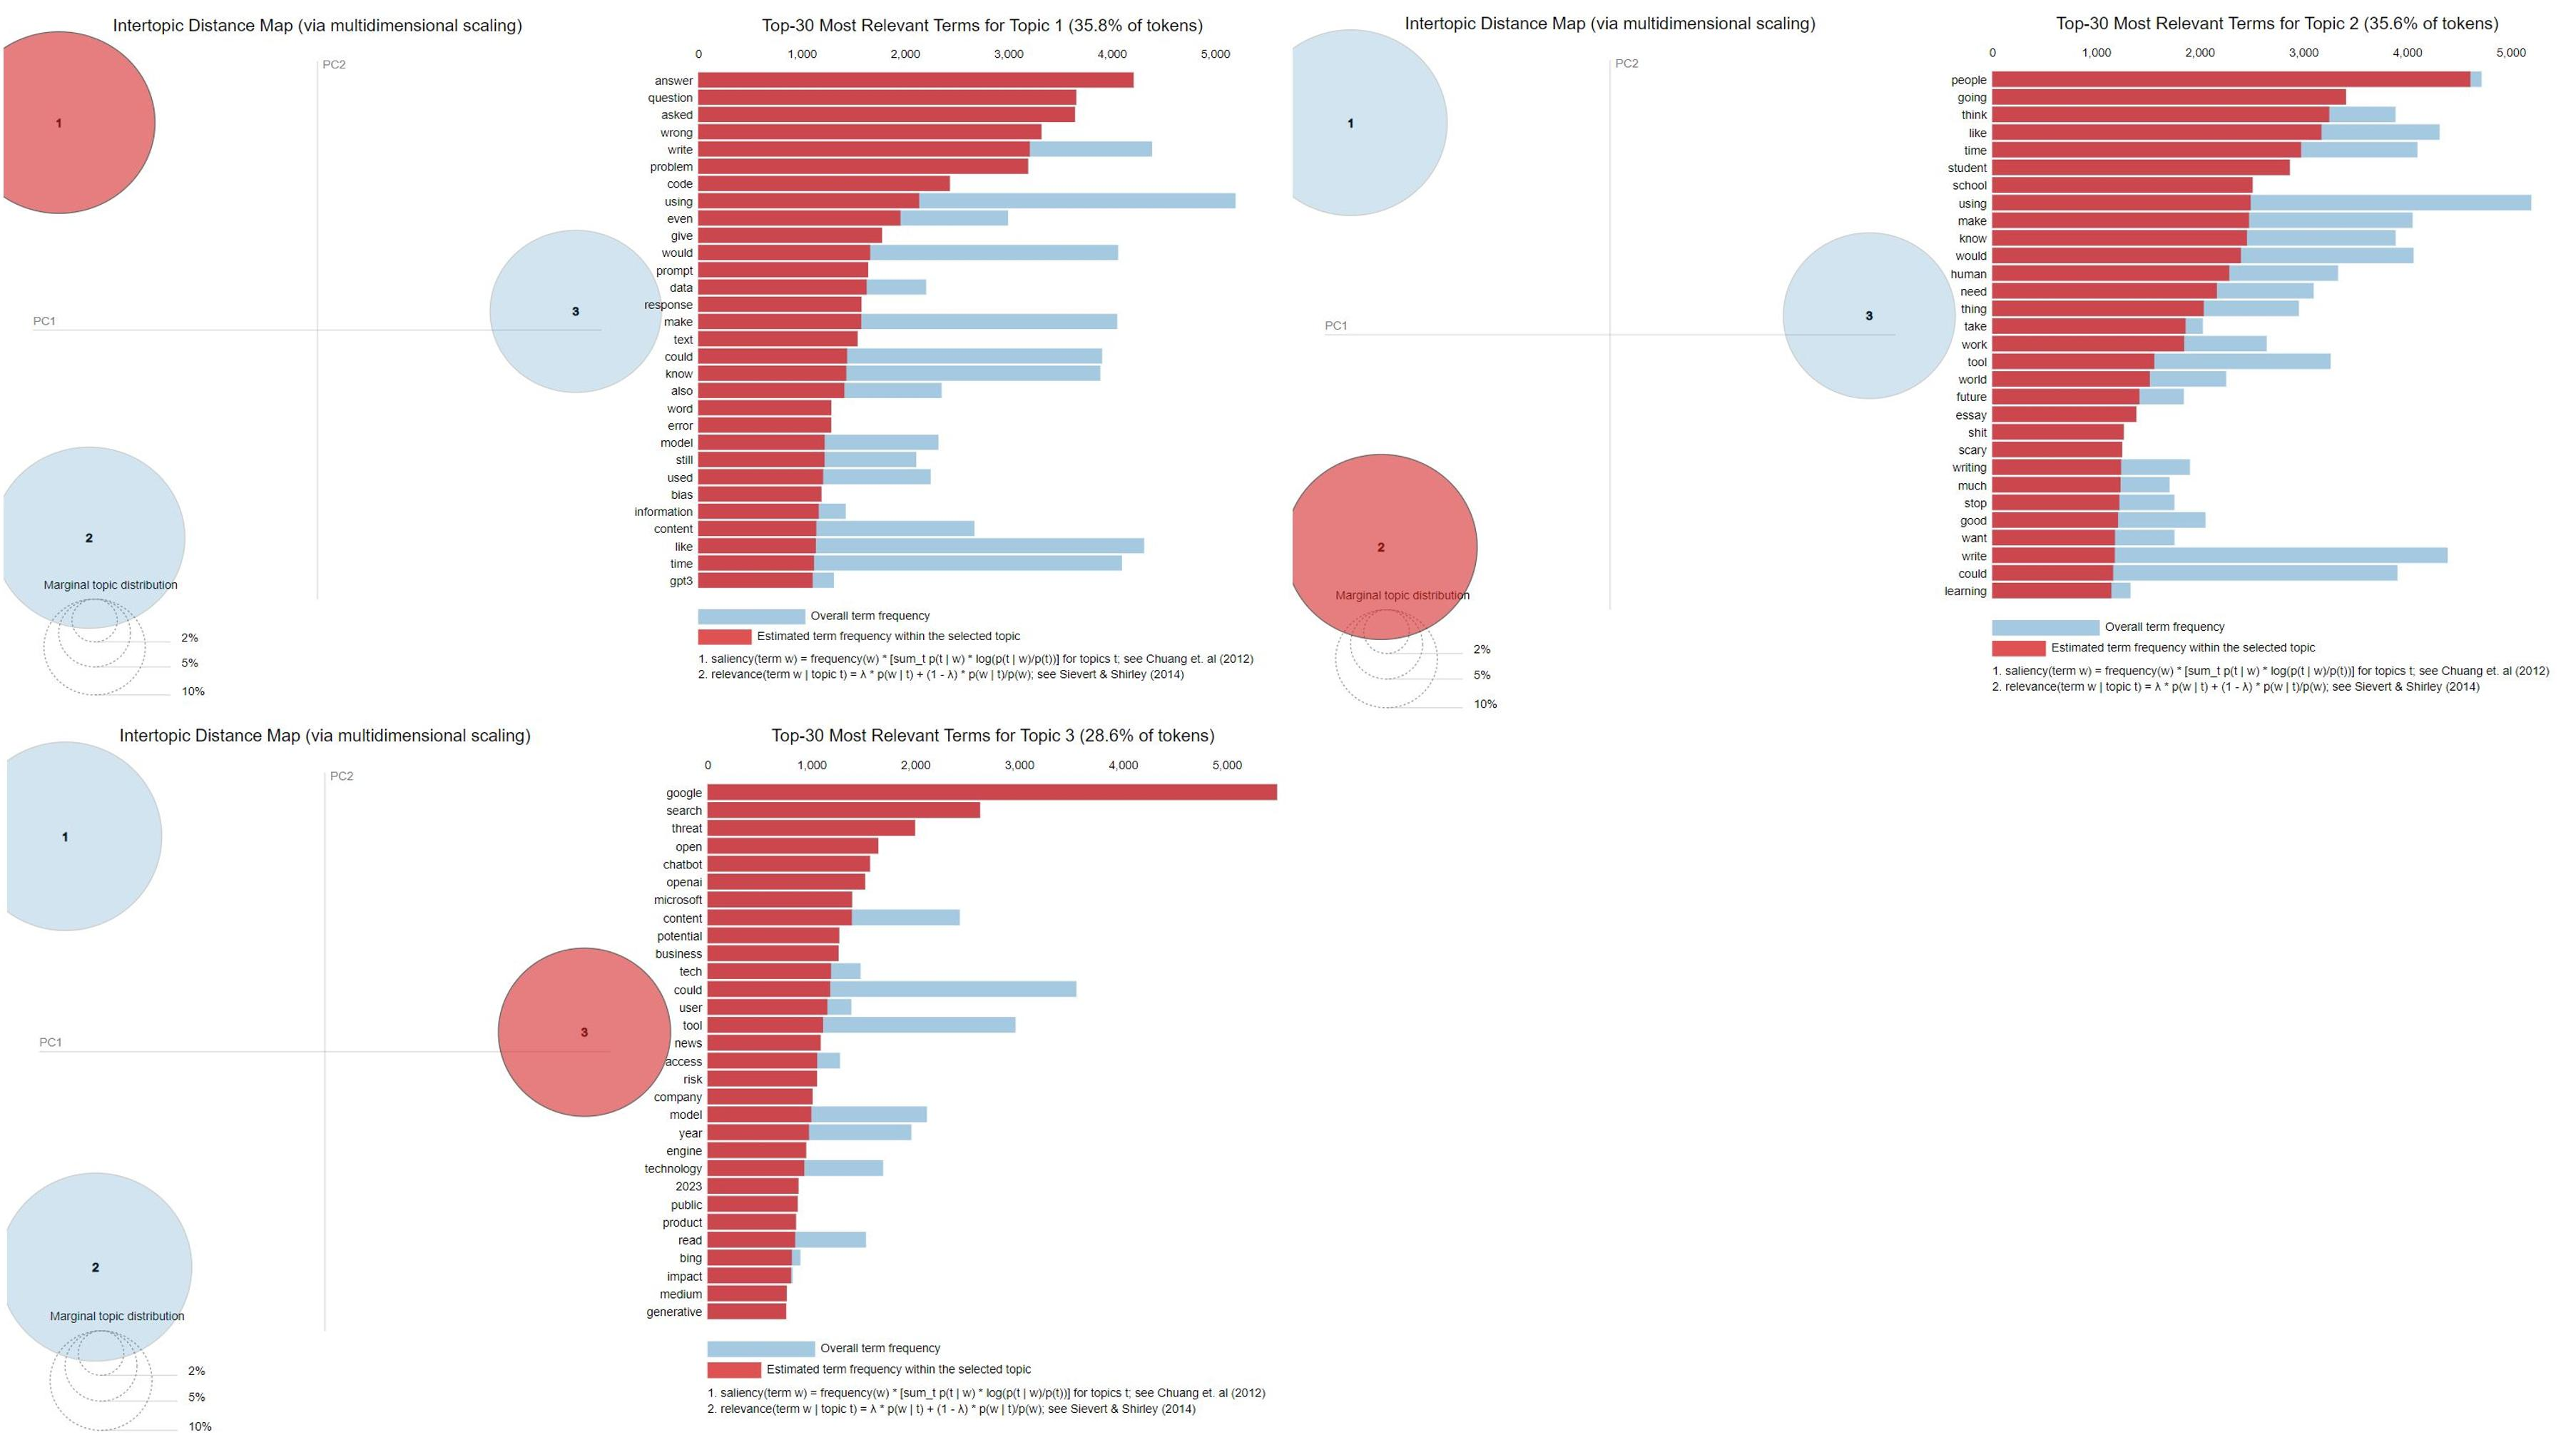

In [25]:
Image.open("contact_neg.jpg")


Distribution of the Topics in Tweets:

In [ ]:
topics_neg = {0:"It's Limitations", 1:"Regarding using \n ChatGPT for \n writing tasks", 2:"Risks involved \n during the \n use of ChatGPT"}
neg_tweet_df["Topic"] = neg_tweet_df["Topic"].apply(lambda x: topics_neg[x])

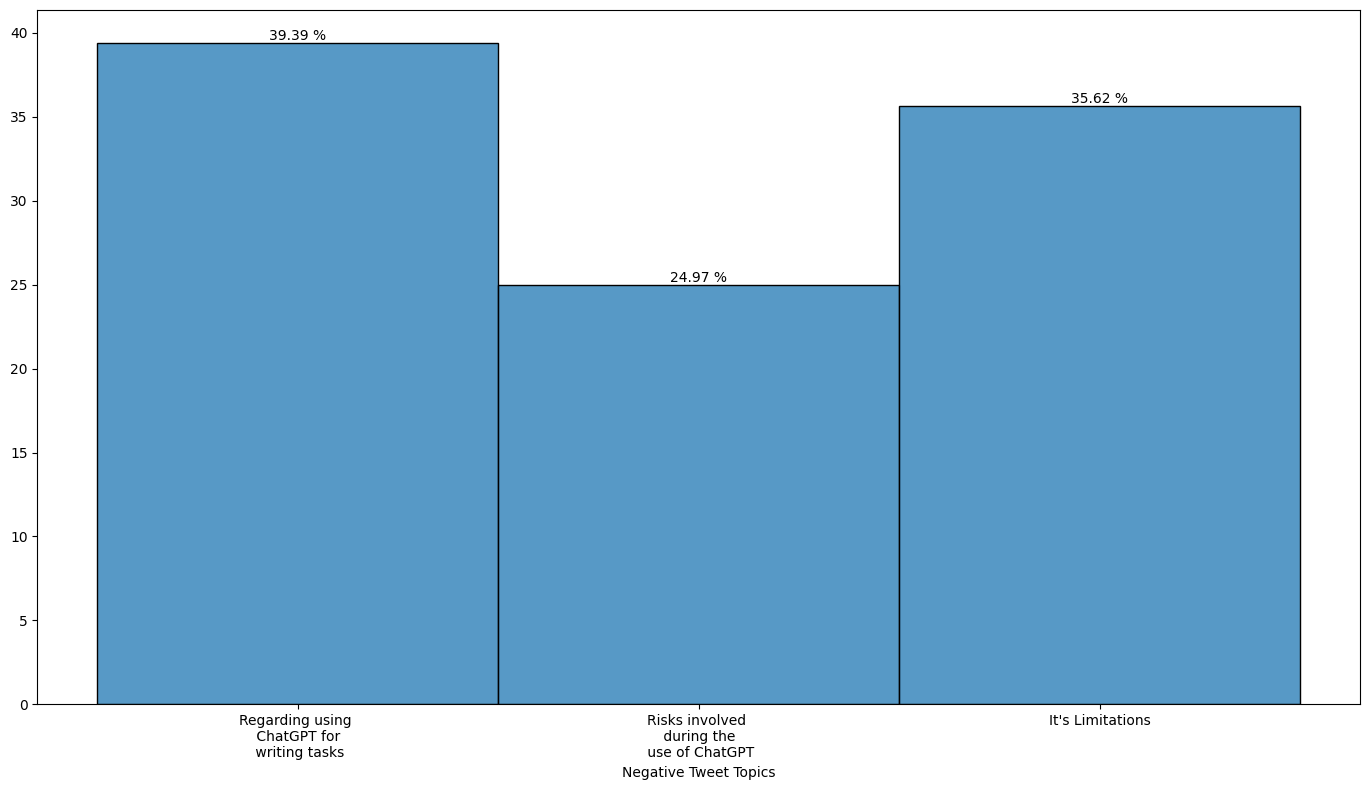

In [54]:
plt.figure(figsize=(14,8))
ax2 = sns.histplot(data=neg_tweet_df, x="Topic", stat="percent" )
plt.tight_layout()
plt.ylabel("")
plt.xlabel("Negative Tweet Topics")
rects = ax2.patches
for rect in rects:
    height = rect.get_height()
    ax2.text(
        rect.get_x() + rect.get_width() / 2, height, str(height)[:5] + " %", ha="center", va="bottom"
    )

##### Possible Topics in Neutral Tweets
Based on the word, in the plots. We can make a subjective inference about possible topics.

Topic 1: Generation of Ideas

Topic 2: Advancements in AI and its Impacts

Topic 3: Upcoming plans for LLMs and investments

In [26]:
pyLDAvis.enable_notebook()
corpus_dict = Dictionary.from_corpus(corpus_neu, id2word=ldamodel_neu.id2word)
vis = pyLDAvis.gensim.prepare(ldamodel_neu, corpus_neu, dictionary=corpus_dict )
pyLDAvis.save_html(vis, 'lda_neu.html')# Can be viewed in html file

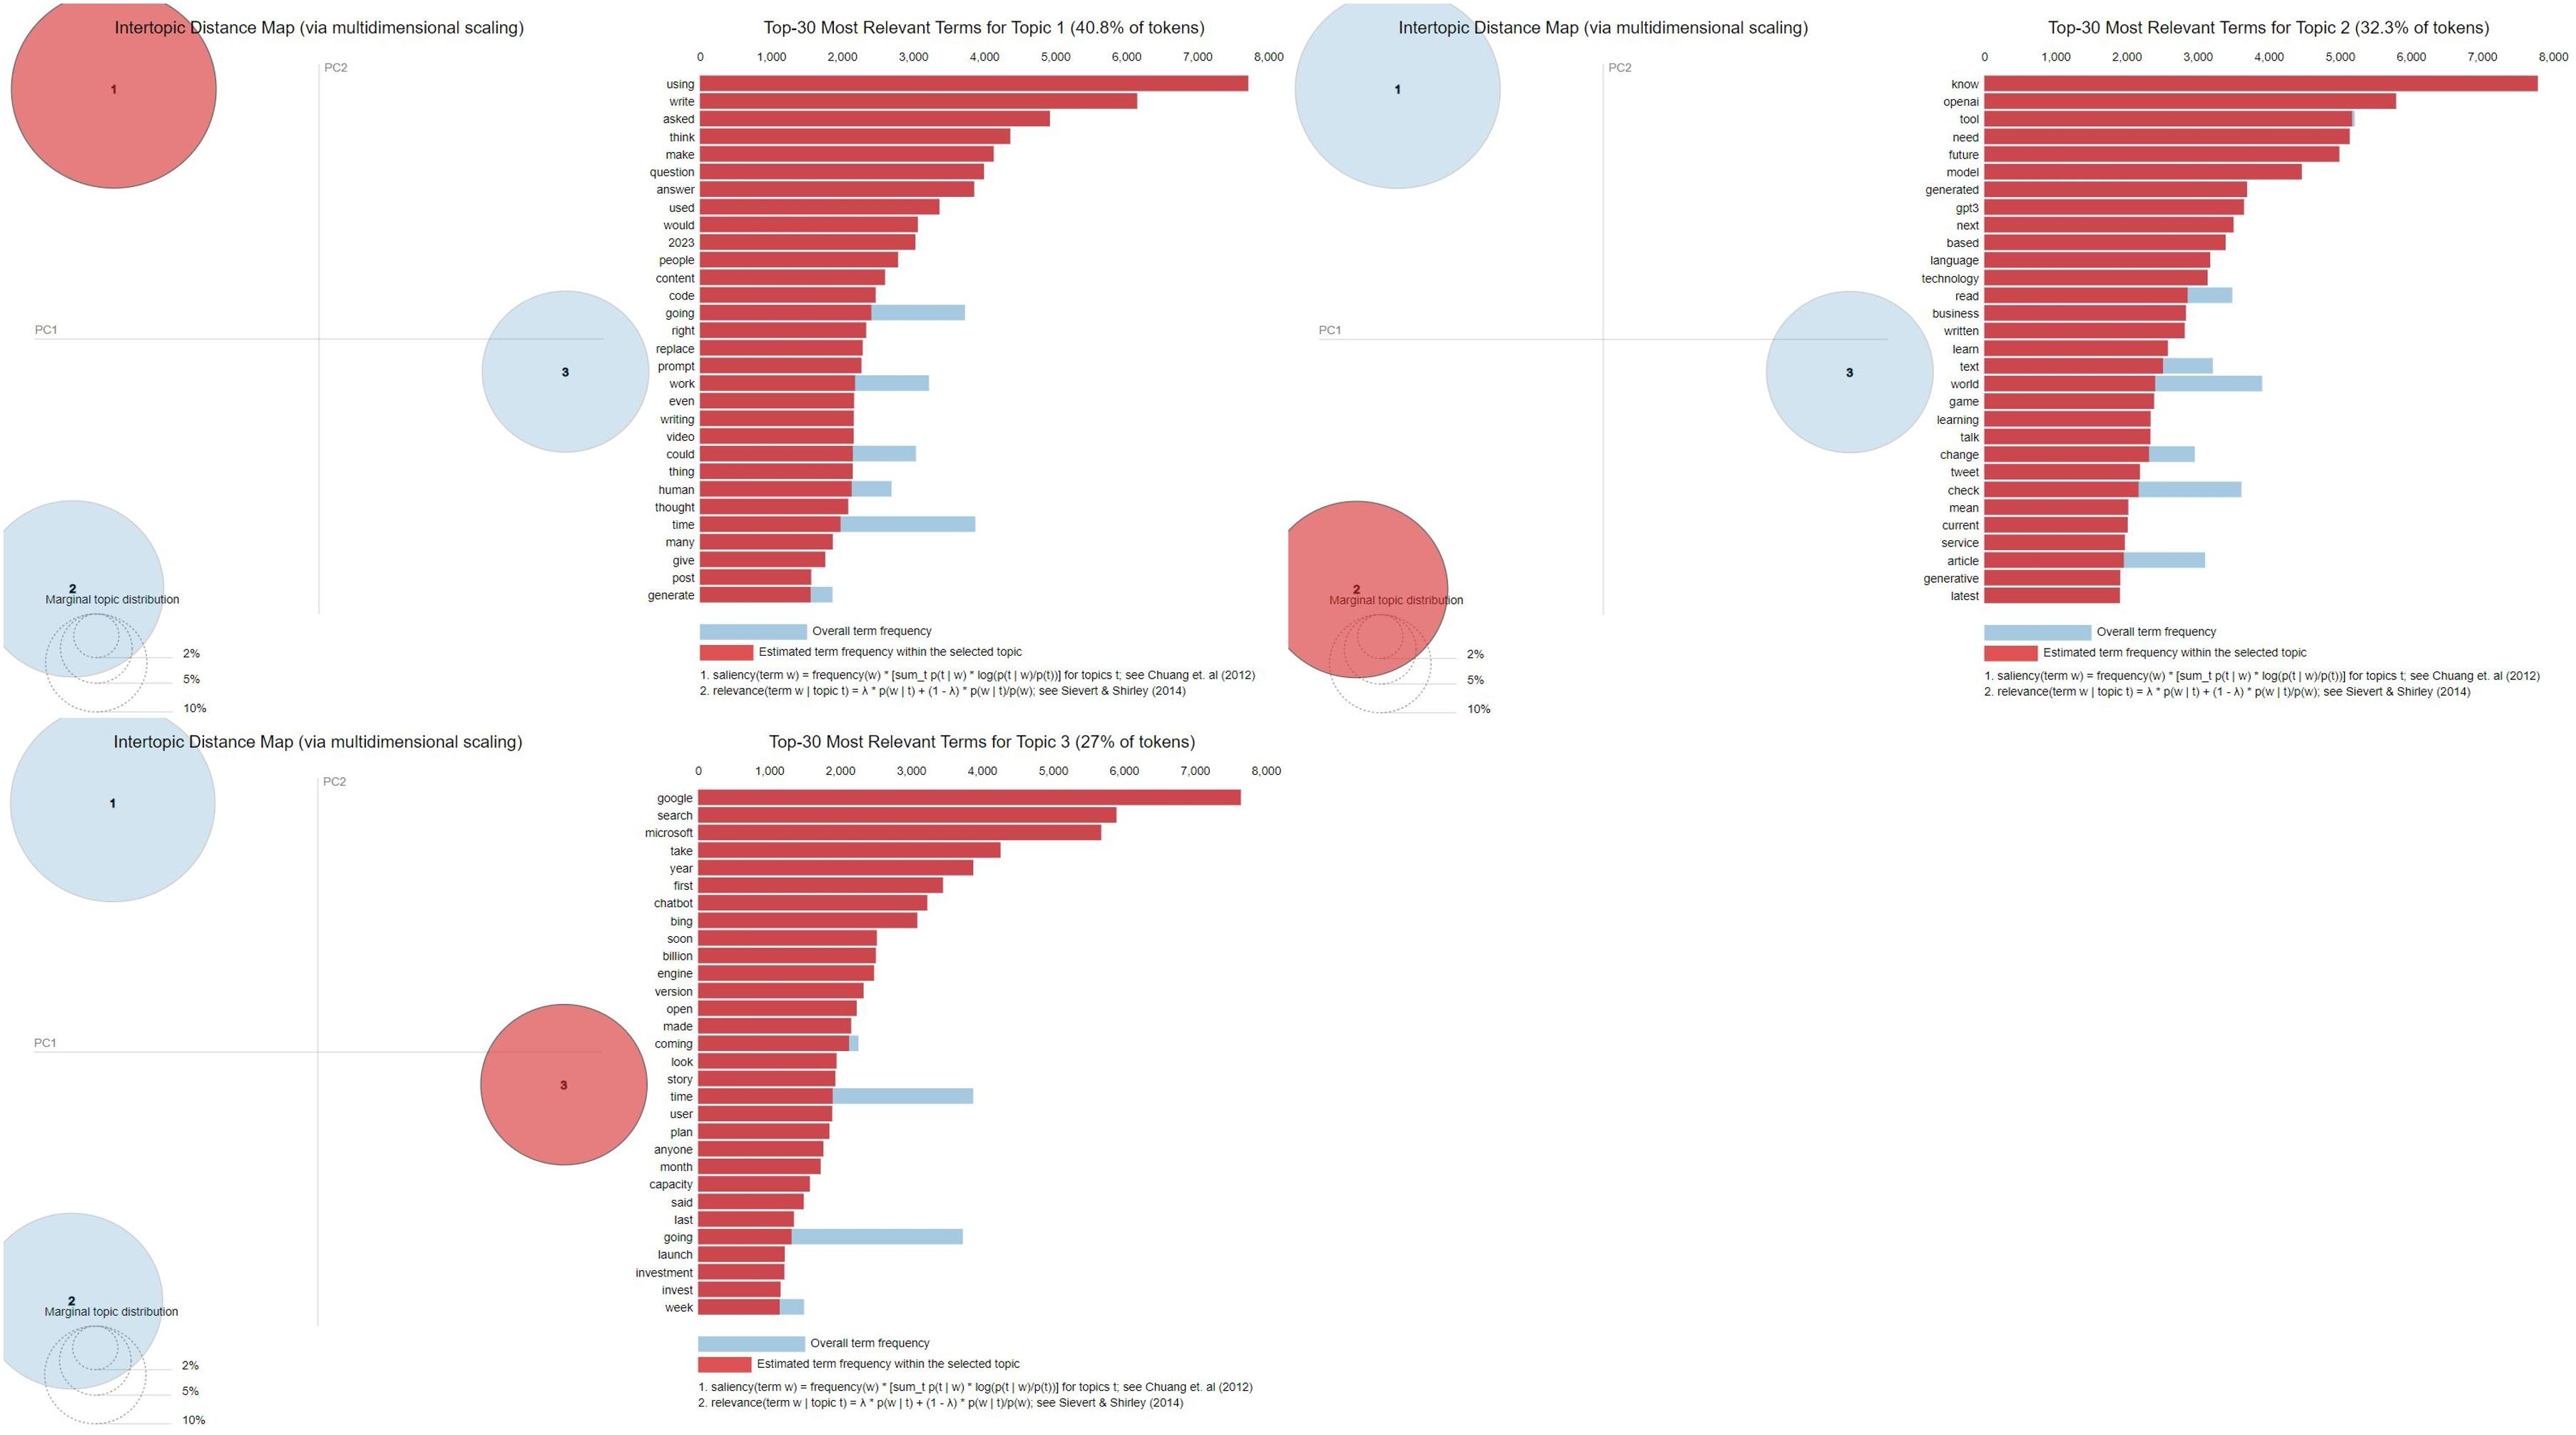

In [27]:
Image.open("contact_neu.jpg")

Distribution of the Topics in Tweets:

In [ ]:
topics_neu = {0:"Generation \n of Ideas", 1:"Advancements in \n AI and its Impacts", 2:"Upcoming plans for \n LLMs and investments"}
neu_tweet_df["Topic"] = neu_tweet_df["Topic"].apply(lambda x: topics_neu[x])

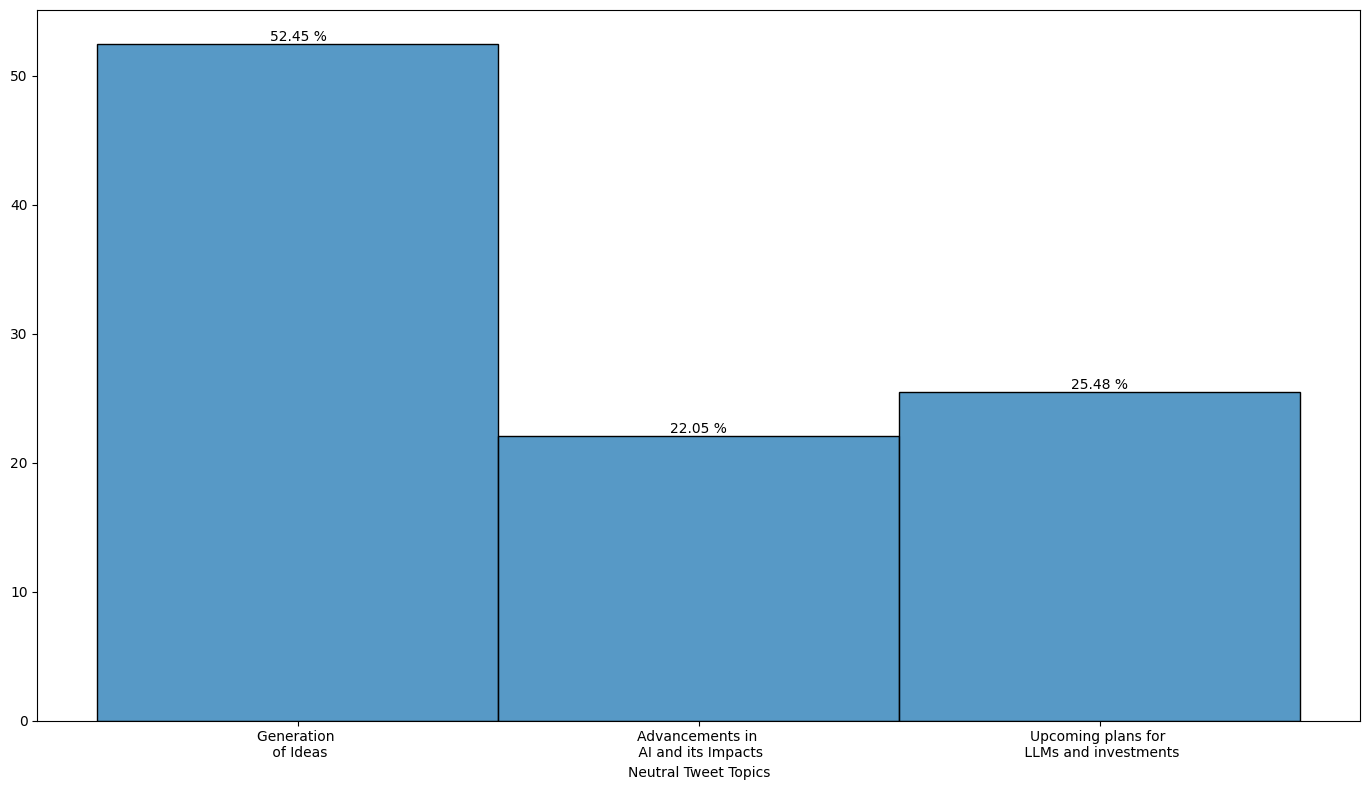

In [55]:
plt.figure(figsize=(14,8))
ax3 = sns.histplot(data=neu_tweet_df, x="Topic", stat="percent" )
plt.tight_layout()
plt.ylabel("")
plt.xlabel("Neutral Tweet Topics")
rects = ax3.patches
for rect in rects:
    height = rect.get_height()
    ax3.text(
        rect.get_x() + rect.get_width() / 2, height, str(height)[:5] + " %", ha="center", va="bottom"
    )